In [1]:
import yaml
import click
import torch
import tqdm.auto
import numpy as np
from torchvision.models import vit_b_16

from matplotlib import pyplot as plt


import sys
import os
import re
import math
#project_root = "C:/Users/elmop/deep_feature_reweighting/deep_feature_reweighting/external/pruning_by_explaining"
project_root = "/home/primmere/ide/external/pruning_by_explaining"
sys.path.insert(0, project_root)                 
sys.path.insert(0, os.path.dirname(project_root))

from pruning_by_explaining.models import ModelLoader
from pruning_by_explaining.metrics import compute_accuracy
from pruning_by_explaining.my_metrics import compute_worst_accuracy
from pruning_by_explaining.my_datasets import WaterBirds, get_sample_indices_for_group, WaterBirdSubset, ISIC, ISICSubset
from pruning_by_explaining.utils import (
    initialize_random_seed,
    initialize_wandb_logger,
)


from pruning_by_explaining.pxp import (
    ModelLayerUtils,
    get_cnn_composite,
    get_vit_composite,
)

from pruning_by_explaining.pxp import GlobalPruningOperations
from pruning_by_explaining.pxp import ComponentAttibution

from pruning_by_explaining.my_experiments.utils import visualise, plot_layer_head_heatmap, plot_layer_head_pruned, plot_r_accuracy_lines



In [2]:
seed = 1
initialize_random_seed(seed)
num_workers = 8
device_string = "cuda"
device = torch.device(device_string)
isic = ISIC(
    "/scratch_shared/primmere/isic/isic_224/raw_224_with_selected", 
    metadata_path='/scratch_shared/primmere/isic/metadata_w_split_v2_w_elmos_modifications.csv', 
    seed=seed, 
    num_workers=num_workers
        )
least_rel_first = True
abs_flag = True
least_rel_first2 = False
abs_flag2 = False
Zplus_flag = True

scale_bool = True

prune_r = [0.96]



layer_type = 'Softmax'

train_set = isic.get_train_set()
val_set = isic.get_valid_set()
test_set = isic.get_test_set()

target_grp = [3]
pruning_indices = get_sample_indices_for_group(val_set, 30, device_string, [0,1,2,3])
pruning_indices2 = get_sample_indices_for_group(val_set, 30, device_string, target_grp)
pruning_indices3 = get_sample_indices_for_group(val_set, 30, device_string, [3])
validation_indices = get_sample_indices_for_group(test_set, 'all', device_string)


custom_pruning_set = WaterBirdSubset(val_set, pruning_indices)
custom_pruning_set2 = WaterBirdSubset(val_set, pruning_indices2)
custom_pruning_set3 = WaterBirdSubset(val_set, pruning_indices3)


train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=num_workers)
prune_dataloader = torch.utils.data.DataLoader(custom_pruning_set, batch_size=1, shuffle=True, num_workers=num_workers)
prune_dataloader2 = torch.utils.data.DataLoader(custom_pruning_set2, batch_size=1, shuffle=True, num_workers=num_workers)
prune_dataloader3 = torch.utils.data.DataLoader(custom_pruning_set3, batch_size=1, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=num_workers)

[0 1 2]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 6314
group 1: 5526
group 2: 1571
[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 60
group 1: 60
group 2: 60
group 3: 60
[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 3158
group 1: 2763
group 2: 882
group 3: 761
target groups: [0, 1, 2, 3]
target groups: [3]
target groups: [3]


In [3]:
suggested_composite = {
        "low_level_hidden_layer_rule": "Epsilon",
        "mid_level_hidden_layer_rule":"Epsilon",
        "high_level_hidden_layer_rule": "Epsilon",
        "fully_connected_layers_rule": "Epsilon",
        "softmax_rule": "Epsilon",
    }
composite = get_vit_composite("vit_b_16", suggested_composite)
layer_types = {
        "Softmax": torch.nn.Softmax,
        "Linear": torch.nn.Linear,
        "Conv2d": torch.nn.Conv2d,
    }

In [4]:
model = ModelLoader.get_basic_model("vit_b_16", '/home/primmere/logs/isic_logs_4/vit_isic_v2.pt', device, num_classes=2)
model2 = ModelLoader.get_basic_model("vit_b_16", '/home/primmere/logs/isic_logs_4/vit_isic_v2.pt', device, num_classes=2)
model3 = ModelLoader.get_basic_model("vit_b_16", '/home/primmere/logs/isic_logs_4/vit_isic_v2.pt', device, num_classes=2)



Arch:vit_b_16


/home/primmere/ide/external/pruning_by_explaining/models/utils.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(checkpoint_path, map_locat

Arch:vit_b_16
Arch:vit_b_16


In [5]:
"""
acc, acc_groups = compute_worst_accuracy(
        model,
        val_dataloader,
        device,
    )
print(acc)
for i in range(len(acc_groups)):
    print(f'{i}: {acc_groups[i]}')
"""



"""
0.8175568482284505
0: 0.9050031665611147
1: 0.9996380745566413
2: 0.4557823129251701
3: 0.21287779237844942
"""


'\n0.8175568482284505\n0: 0.9050031665611147\n1: 0.9996380745566413\n2: 0.4557823129251701\n3: 0.21287779237844942\n'

In [6]:
component_attributor = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first
    )

components_relevances = component_attributor.attribute(
        model,
        prune_dataloader,
        composite,
        abs_flag=abs_flag,
        Zplus_flag=False,
        device=device,
    )

layer_names = component_attributor.layer_names
pruner = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names,
    )


/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [7]:
component_attributor2 = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first2
    )

components_relevances2 = component_attributor2.attribute(
        model2,
        prune_dataloader2,
        composite,
        abs_flag=abs_flag2,
        Zplus_flag=Zplus_flag,
        device=device,
    )
layer_names2 = component_attributor.layer_names
pruner2 = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names2,
    )



In [8]:
component_attributor3 = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first2
    )

components_relevances3 = component_attributor3.attribute(
        model3,
        prune_dataloader3,
        composite,
        abs_flag=abs_flag2,
        Zplus_flag=Zplus_flag,
        device=device,
    )
layer_names3 = component_attributor.layer_names
pruner3 = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names3,
    )


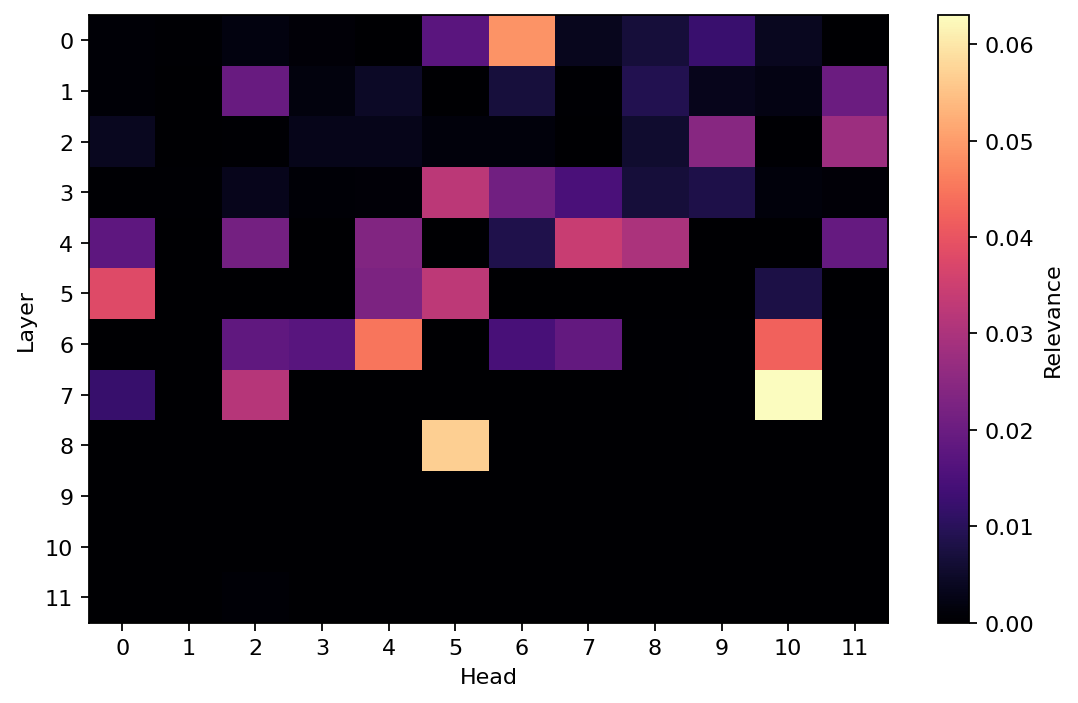

(<Figure size 1120x720 with 2 Axes>, <Axes: xlabel='Head', ylabel='Layer'>)

In [9]:
plot_layer_head_heatmap(components_relevances2, normalise = len(pruning_indices), save_path = f'heatmaps/isic_{layer_type}_{target_grp[0]}')

In [10]:
#plot_layer_head_heatmap(components_relevances, normalise = len(pruning_indices))

In [11]:
#plot_layer_head_heatmap(components_relevances2, normalise = len(pruning_indices2))

In [12]:
#plot_layer_head_heatmap(components_relevances3, normalise = len(pruning_indices3))

In [13]:
scale = len(pruning_indices)
if scale_bool:
    for t in components_relevances.values():
        t.div_(scale)

In [14]:
"""
for k,v in components_relevances.items():
    if "mlp.3" in k:
        v.div_(4)

for k,v in components_relevances2.items():
    if "mlp.3" in k:
        v.div_(4)

for k,v in components_relevances3.items():
    if "mlp.3" in k:
        v.div_(4)

"""

'\nfor k,v in components_relevances.items():\n    if "mlp.3" in k:\n        v.div_(4)\n\nfor k,v in components_relevances2.items():\n    if "mlp.3" in k:\n        v.div_(4)\n\nfor k,v in components_relevances3.items():\n    if "mlp.3" in k:\n        v.div_(4)\n\n'

In [15]:
scale2 = len(pruning_indices2)
scale3 = len(pruning_indices3)
if scale_bool :
    for t in components_relevances2.values():
        t.div_(scale2*2)
    for t in components_relevances3.values():
        t.div_(scale3)

In [16]:
print(scale, scale2, scale3)

120 30 30


In [17]:
for k in components_relevances2.keys():
    #print(torch.mean(v))
    a = torch.mean(components_relevances[k]).item()
    b = torch.mean(components_relevances2[k]).item()
    c = torch.mean(components_relevances3[k]).item()
    print(f'{a:.3f}, {b:.3f}, {c:.3f}')

0.195, 0.016, 0.042
0.255, 0.011, 0.041
0.184, 0.012, 0.031
0.273, 0.015, 0.053
0.346, 0.026, 0.085
0.252, 0.017, 0.038
0.295, 0.026, 0.061
0.206, 0.018, 0.039
0.089, 0.009, 0.030
0.000, 0.000, 0.000
0.000, 0.000, 0.000
0.001, 0.000, 0.000


In [18]:
for name, R in components_relevances.items():
    print(name, torch.sum(R).item())

encoder.layers.encoder_layer_0.self_attention.softmax 2.3352534770965576
encoder.layers.encoder_layer_1.self_attention.softmax 3.0611400604248047
encoder.layers.encoder_layer_2.self_attention.softmax 2.2133126258850098
encoder.layers.encoder_layer_3.self_attention.softmax 3.279086112976074
encoder.layers.encoder_layer_4.self_attention.softmax 4.1520915031433105
encoder.layers.encoder_layer_5.self_attention.softmax 3.019782781600952
encoder.layers.encoder_layer_6.self_attention.softmax 3.5361452102661133
encoder.layers.encoder_layer_7.self_attention.softmax 2.4675214290618896
encoder.layers.encoder_layer_8.self_attention.softmax 1.0648659467697144
encoder.layers.encoder_layer_9.self_attention.softmax 9.943318168836868e-09
encoder.layers.encoder_layer_10.self_attention.softmax 3.027709567504644e-07
encoder.layers.encoder_layer_11.self_attention.softmax 0.008416786789894104


In [19]:
combined_relevances = {}
check = True
for (k1, v1), (k2, v2), (k3, v3) in zip(
        components_relevances.items(), components_relevances2.items(), components_relevances3.items()
):
    check = check & (k1==k2==k3)
    combined_relevances[k1] = v1 - v3
print(check)

True


In [20]:
accs = np.zeros((len(prune_r),6))
i = 0
for r in prune_r:
    global_pruning_mask_combined = pruner.generate_global_pruning_mask(
                    model,
                    combined_relevances,
                    r,
                    subsequent_layer_pruning=layer_type,
                    least_relevant_first=True,
                    device=device,
                )
    hook_handles = pruner.fit_pruning_mask(model, global_pruning_mask_combined,)
    acc, acc_groups = compute_worst_accuracy(
            model,
            val_dataloader,
            device,
        )
    accs[i]=np.array([r,acc,acc_groups[0],acc_groups[1],acc_groups[2],acc_groups[3]])
    i+=1
    print(f'{r} & {acc:.3f} & {acc_groups[0]:.3f} & {acc_groups[1]:.3f} & {acc_groups[2]:.3f} & {acc_groups[3]:.3f} \\\\')
    #visualise(global_pruning_mask_combined, r, layer_type)

evaluating group acc:   0%|          | 0/237 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_r_accuracy_lines(accs)

In [ ]:
"""0.85 & 0.818 & 0.899 & 0.999 & 0.474 & 0.219 \\
0.88 & 0.817 & 0.896 & 0.999 & 0.478 & 0.222 \\
0.9 & 0.816 & 0.894 & 1.000 & 0.472 & 0.229 \\
0.92 & 0.821 & 0.891 & 0.999 & 0.485 & 0.272 \\
0.95 & 0.841 & 0.868 & 0.992 & 0.559 & 0.509 \\"""

In [ ]:
count=0
for n, t in global_pruning_mask_combined.items():
    param_total = t['Linear']['weight'].numel()
    param_nonzero = t['Linear']['weight'].nonzero().size(0)
    param_shape = t['Linear']['weight'].shape
    
    pruned = (param_total-param_nonzero)/param_shape[1]
    total = param_total/param_shape[1]
    #print(pruned, "/", total, "pruned,", pruned/total)
    print(f'{100*pruned/total:.1f}% - {pruned} / {total} pruned')
    

In [ ]:
"""
acc, acc_groups = compute_worst_accuracy(
        model,
        val_dataloader,
        device,
    )
print(acc)
for i in range(4):
    print(f'{i}: {acc_groups[i]}')

"""

In [ ]:
#global_pruning_mask

In [ ]:
#global_pruning_mask2

In [ ]:
for v, v2 in zip(components_relevances.values(), components_relevances2.values()):
    print(v[0:8])
    print(v2[0:8])
    print(v[0:8]-v2[0:8])
    print("--")

In [ ]:
print(f'{prune_r},{acc:.3f},{acc_groups[0]:.3f},{acc_groups[1]:.3f},{acc_groups[2]:.3f},{acc_groups[3]:.3f}')

In [ ]:
print(f'{r} & {acc:.3f} & {acc_groups[0]:.3f} & {acc_groups[1]:.3f} & {acc_groups[2]:.3f} & {acc_groups[3]:.3f} \\\\')

In [ ]:
layer_type

In [ ]:
visualise(global_pruning_mask_combined, r, layer_type)

In [ ]:
torch.save(model.state_dict(), "checkpoints/isic_30_0123_minus_3_r0.96.pth")